## Notes 
### Required installing Oracle JAVA 8 to get javabridge installed
### Then, I was able to install py-causal from https://bd2kccd.github.io/docs/py-causal/
### GFCI is slower than RFCI, but more accurate (SPIRTES), GFCI and RFCI account for unobserved variables, FGES assumes no unobserved variables.

Structure Learning Performance Guarantees If the assumptions in the previous section hold, then in the large sample limit, the CBN structure output by GFCId will contain an edge of one of four kinds between Xand Y   if and only if Xand Yare not independent conditional on any subset of the other measured variables of less than or equal to a specified size. In addition, there is (1) an arc X->Y   if and only if Xdirectly or indirectly causes Y, and Y   does not directly or indirectly cause X; (2) an edge X <-->Y   if and only if X   is not a direct or indirect cause of Yand Y   is not a direct or indirect cause of X(which can only occur if there are latent confounders of Xand some other variable or Yand some other variable; (3) an edge Xo->Y   only if Yis not a direct or indirect cause of X, but Xmay or may not be an indirect cause of Y; (4) an edge X o–o Y   indicates that Xand Y   are dependent no matter what subset of observed variables is conditioned on, but contains no orientation information (X   may be a direct or indirect cause of Y, and Ymay be an indirect cause of X, or there may be a latent common cause of Xand Y.

# Trying some various ML models

In [1]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="0" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))

    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model


/home/tkyono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s




def discrete_gauss(low, high, samples, std = 20):
    x = np.arange(low, high)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.norm.cdf(xU, scale = std) - ss.norm.cdf(xL, scale = std)
    prob = prob / prob.sum() #normalize the probabilities so their sum is 1
    nums = np.random.choice(x, size = samples, p = prob)
    return nums



def bar_plot(x_ax, val1, val1std, val2, val2std):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ## the data
    N = len(x_ax)

    ## necessary variables
    ind = np.arange(N)                # the x locations for the groups
    width = 0.35                      # the width of the bars
    fig.set_size_inches(18.5, 10.5)
    ## the bars
    rects1 = ax.bar(ind, val1, width,
                    color='gray',
                    yerr=val1std,
                    error_kw=dict(elinewidth=2,ecolor='blue'))

    rects2 = ax.bar(ind+width, val2, width,
                        color='blue',
                        #yerr=val2std,
                        error_kw=dict(elinewidth=2,ecolor='gray'))

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    #ax.set_ylim(0,45)
    ax.set_ylabel('Percentage')
    ax.set_title('')
    plt.xticks(ind + width / 2, x_ax, rotation=75, size = 14)
    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('Accuracy', '% Violations') )
    fig.savefig("violations.pdf", bbox_inches='tight')
    plt.show()





def gen_data(mean = 0, var = 1, SIZE = 5000):
    a = np.random.gumbel(mean, var, SIZE)
    b = np.random.gumbel(mean, var, SIZE)
    c = np.random.gumbel(mean, var, SIZE)
    d = np.random.gumbel(mean, var, SIZE)
    e = np.random.gumbel(mean, var, SIZE)
    f= a + b + c + d + e + np.random.gumbel(mean, var, SIZE)
    g = f + np.random.gumbel(mean,var, SIZE)
    g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 1, SIZE = 5000):
    a = np.random.gumbel(mean, var, SIZE)
    b = np.random.gumbel(mean, var, SIZE)
    c = np.random.gumbel(mean, var, SIZE)
    d = np.random.gumbel(mean, var, SIZE)

    f= a + b + c + d + np.random.gumbel(mean, var, SIZE)
    g = f + np.random.gumbel(mean,var, SIZE)
    
    
    g = np.rint(g)
    e = g + np.random.gumbel(mean,var,SIZE)
    
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})


def gen_data(mean = 0, var = 1, SIZE = 400000):
    f = np.random.normal(mean, var, SIZE)
    a = f + np.random.normal(mean, var, SIZE)
    b = f + np.random.normal(mean, var, SIZE)
    c = f + np.random.normal(mean, var, SIZE)
    d = f + np.random.normal(mean, var, SIZE)
    e = f + np.random.normal(mean, var, SIZE)
    g = a + b + c + d  + e + np.random.normal(mean, var, SIZE)

    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = np.random.normal(mean, var, SIZE)
    c = np.random.normal(mean, var, SIZE)
    d = np.random.normal(mean, var, SIZE)
    e = np.random.normal(mean, var, SIZE)
    f= a + b + c + d + e + np.random.normal(mean, var, SIZE)
    g = f + np.random.normal(mean,var, SIZE)
    #g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = a + np.random.normal(mean, var, SIZE)
    c = a + np.random.normal(mean, var, SIZE)
    d = a + np.random.normal(mean, var, SIZE)
    e = a + np.random.normal(mean, var, SIZE)
    f= a + np.random.normal(mean, var, SIZE)
    g = f + np.random.normal(mean,var, SIZE)
    #g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def get_CG(df, tetrad):
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
           structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
           completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    #tetrad.run(algoId = 'fges-mb', targetName = 'g', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
    #       structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
    #       completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)


    return tetrad.getTetradGraph()

def get_MB(graph, var, pc):
    parents = set()
    children = set()
    for i in pc.extractTetradGraphEdges(graph):
        if i[-1] == var and i[3:5] == '->':
            parents.add(i[0])
        if i[0] == var and i[3:5] == '->':
            children.add(i[-1])
    return parents, children

from pycausal.pycausal import pycausal as pc
from collections import defaultdict
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()






verbosity = 0




import random

num_models = 50
layers = [256, 512, 1024, 2048, 4096]
models = []
model_names = []
for i in range(num_models):
    network = []
    for j in range(3):
        network.append(layers[random.randint(0,len(layers) -1)])
    models.append(network)
    model_names.append('temp/random' + str(i))
print(models, model_names)    
df = gen_data()
X = df[['a', 'b', 'c', 'd', 'e', 'f']].values
y = df['g'].values

val_df = gen_data(SIZE = 10000)
x_val = df[['a', 'b', 'c', 'd', 'e', 'f']].values
y_val = df['g'].values




/home/tkyono/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


[[256, 1024, 2048], [512, 2048, 2048], [1024, 4096, 4096], [2048, 2048, 1024], [512, 1024, 2048], [4096, 2048, 4096], [1024, 256, 256], [256, 512, 4096], [512, 256, 2048], [512, 2048, 512], [256, 2048, 256], [2048, 256, 256], [4096, 512, 1024], [1024, 2048, 512], [2048, 256, 256], [512, 4096, 256], [512, 2048, 2048], [256, 2048, 4096], [1024, 256, 2048], [256, 4096, 256], [2048, 1024, 1024], [512, 1024, 2048], [1024, 4096, 512], [512, 4096, 256], [2048, 4096, 512], [512, 1024, 256], [256, 4096, 256], [512, 256, 2048], [256, 4096, 256], [2048, 2048, 512], [2048, 512, 4096], [1024, 1024, 256], [512, 1024, 1024], [1024, 512, 256], [1024, 256, 2048], [4096, 256, 256], [512, 1024, 256], [256, 512, 256], [2048, 4096, 1024], [256, 1024, 2048], [2048, 256, 512], [256, 256, 4096], [256, 256, 4096], [4096, 4096, 1024], [1024, 1024, 2048], [512, 4096, 4096], [2048, 256, 1024], [2048, 4096, 1024], [512, 512, 512], [512, 512, 4096]] ['temp/random0', 'temp/random1', 'temp/random2', 'temp/random3', '

In [3]:
for idx, model_name in enumerate(model_names):
    print(model_name)

    if type(models[idx]) is list:
        #clear session
        keras.backend.clear_session() 
        #get model according to specification
        model = get_model(models[idx], [0.2] * len(models), 6)
        callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                     EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
        model.compile(optimizer = optimizers.SGD(lr = 0.01, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
        #print(len(X), len(y))
        model.fit(X, y, epochs = 20, validation_data = (x_val, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
    else:
        models[idx].fit(X,y)


temp/random0
temp/random1
temp/random2
temp/random3
temp/random4
temp/random5
temp/random6
temp/random7
temp/random8
temp/random9
temp/random10
temp/random11
temp/random12
temp/random13
temp/random14
temp/random15
temp/random16
temp/random17
temp/random18
temp/random19
temp/random20
temp/random21
temp/random22
temp/random23
temp/random24
temp/random25
temp/random26
temp/random27
temp/random28
temp/random29
temp/random30
temp/random31
temp/random32
temp/random33
temp/random34
temp/random35
temp/random36
temp/random37
temp/random38
temp/random39
temp/random40
temp/random41
temp/random42
temp/random43
temp/random44
temp/random45
temp/random46
temp/random47
temp/random48
temp/random49


In [4]:
nb_test = 2000
metrics_dicts = []
for m in models:
    metrics_dicts.append(defaultdict(list))


#means = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#variances = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
means = [0, 1, 2]
variances = [1,2,3]


# ok at this point we need to check the model on various variances and means
for m in means:
    for v in variances:
        print(m,v)
        #t0 = time.time()
        perturbed_df = gen_data(mean =m, var = v, SIZE = nb_test)
        y_test2 = perturbed_df['g']
        x_test2 = perturbed_df[['a', 'b', 'c', 'd', 'e', 'f']]
        #t1 = time.time()
        #print("Time for gen_data = ", t1 - t0)
        for idx, model_name in enumerate(model_names):
            #t0 = time.time()
            if type(models[idx]) is list:
                keras.backend.clear_session()
                model = load_model(model_name)
            else:
                model = models[idx]
            #t1 = time.time()
            #print("Time to load model = ", t1 - t0)
            
            y_pred2 = model.predict(x_test2)
            metrics_dicts[idx][str(m) + '_' + str(v)].append(mean_squared_error(y_test2, y_pred2))

            test_df2 = pd.DataFrame(x_test2, columns = ['a', 'b', 'c', 'd', 'e', 'f'])
            test_targets2 = pd.DataFrame(model.predict(x_test2), columns = ['g'])
            test_df2 = test_df2.join(test_targets2)
'''
            setA = get_MB(get_CG(perturbed_df, tetrad), 'g', pc)
            if setA != {'f'}:
                print("Error in SETA markov blanket")
                #setA = {'f'}
            setC = get_MB(get_CG(test_df2, tetrad), 'g', pc)

            if setA != setC:
                causal_dicts[idx][str(m) + '_' + str(v)].append(1)
            else:
                causal_dicts[idx][str(m) + '_' + str(v)].append(0)

'''




0 1
0 2
0 3
1 1
1 2
1 3
2 1
2 2
2 3


'\n            setA = get_MB(get_CG(perturbed_df, tetrad), \'g\', pc)\n            if setA != {\'f\'}:\n                print("Error in SETA markov blanket")\n                #setA = {\'f\'}\n            setC = get_MB(get_CG(test_df2, tetrad), \'g\', pc)\n\n            if setA != setC:\n                causal_dicts[idx][str(m) + \'_\' + str(v)].append(1)\n            else:\n                causal_dicts[idx][str(m) + \'_\' + str(v)].append(0)\n\n'

# USING BIC

In [5]:
#the number of times to sample 
times = 10

## the size of the test set


violations = np.zeros(len(models))
violation_mean = np.zeros((len(models), times))
violation_mean2 = np.zeros((len(models), times))
mean = np.zeros((len(models), times))

fold = 0

#metrics_dicts = []
causal_dicts = []
for m in models:
#    metrics_dicts.append(defaultdict(list))
    causal_dicts.append(defaultdict(list))
from pycausal import prior as p
def get_bic(df):
    #prior = p.knowledge(requiredirect =  [['a', 'f'], 
    #                                  ['b', 'f'], 
    #                                  ['c', 'f'],
    #                                  ['d', 'f'], 
    #                                  ['e', 'f'], 
    #                                  ['f', 'g']
    #                                 ])
    
    prior = p.knowledge(requiredirect =  [['a', 'b'], ['a', 'c'], ['a', 'd'], ['a', 'e'],['a', 'f'],['f', 'g']])
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC / len(df)

for t in range(times):
    print("Times = ", t)
    df_test = gen_data(SIZE = nb_test)
    x_test = df_test[['a', 'b', 'c', 'd', 'e', 'f']].values
    y_test = df_test['g'].values
    bic_orig = get_bic(df_test)

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]
        test_df = pd.DataFrame(x_test, columns = ['a', 'b', 'c', 'd', 'e', 'f'])
        test_targets = pd.DataFrame(model.predict(x_test), columns = ['g'])
        test_df = test_df.join(test_targets)
        mean[idx][t] = mean_squared_error(y_test, model.predict(x_test))  
        bic_pred = get_bic(test_df)
        violation_mean[idx][t] = bic_orig - bic_pred
        violation_mean2[idx][t] = bic_orig - bic_pred
        print(bic_orig - bic_pred)



Times =  0
-0.7772906141920406
-0.6760604909541885
-0.7346129755839619
-0.5480384402385101
-0.79118506989788
-0.7158828316393606
-0.7487772547611788
-0.9554434376699756
-0.8301751639508264
-0.8879466814891224
-0.6837977144750225
-0.6474564396471227
-0.6825495562499766
-0.6830989833304622
-0.6753911552279726
-0.6791635449135085
-0.7582405315348542
-0.6757941332489978
-0.7398807878860589
-0.6115567176282086
-0.698083792947187
-0.7783758470969113
-0.555125923220368
-0.5192224207592786
-0.7186900306479465
-0.6675531148973106
-0.708629483958668
-0.9398661502314241
-0.8568433896388776
-0.8835730755380915
-0.9231696156848006
-0.7942551617923908
-1.2012991440180267
-0.5847629242924781
-0.7337466232110317
-0.831949887568272
-1.0710375231988614
-0.5843590565532333
-0.9659235579747616
-0.5411975175249908
-0.6618746035912326
-0.7444933029536585
-0.6684860934319623
-0.6041833338226659
-0.9020608899759042
-0.6938382413690061
-0.9004539775497875
-0.6459535652740915
-0.7863774189605746
-1.200655954495

-0.7833407727955422
-0.8735033967684633
-0.6638871310966086
-0.6378557253160237
-0.6910854542305711
-0.6646595735490064
-0.6063284479376798
-0.6588117243763092
-0.7665163464645564
-0.6717986858777394
-0.7194012713057703
-0.5995974052209982
-0.7067786250883756
-0.7674736972964886
-0.5619110478209035
-0.4829220217769312
-0.7206341714896218
-0.6431549807989385
-0.6472773254931194
-0.855394364591584
-0.8470986522225488
-0.7962827744967635
-0.8630309719925884
-0.8231537120063666
-1.0853458010774972
-0.5031477699079505
-0.7109714806518239
-0.8270227331931963
-0.9780441433070637
-0.5606088729052101
-0.8430217760692738
-0.49159851874462657
-0.6415748234981664
-0.7425265812451514
-0.6365427920043172
-0.6455589280830312
-0.8905754050602961
-0.6917882697456745
-0.9547253310488397
-0.6284007934429279
-0.780883863627724
-1.078471129903716
Times =  9
-0.7434884797987737
-0.6285153116725017
-0.6691492844929336
-0.5400216181763411
-0.7888412816194768
-0.7096961231908567
-0.6995508098505621
-0.88190255

Model_name =  temp/random0 Violations =  0.0
Average_violations =  -0.7438808714330353 0.03365043681133525
MSE =  1.0546874160728301 0.033323080047999054
Model_name =  temp/random1 Violations =  0.0
Average_violations =  -0.6659471915856855 0.03782007383372636
MSE =  1.0176499922772726 0.03658065251864135
Model_name =  temp/random2 Violations =  0.0
Average_violations =  -0.7210205539992576 0.02764270443469513
MSE =  1.0167957060373218 0.03287802622821547
Model_name =  temp/random3 Violations =  0.0
Average_violations =  -0.5687341942755924 0.034582684983947766
MSE =  1.0338554801812816 0.03454664939704408
Model_name =  temp/random4 Violations =  0.0
Average_violations =  -0.7939659723808095 0.036505609901299314
MSE =  1.0186968778464343 0.03481396974823439
Model_name =  temp/random5 Violations =  0.0
Average_violations =  -0.7197591841040283 0.03338266257301116
MSE =  1.0150139724032319 0.031429404743202216
Model_name =  temp/random6 Violations =  0.0
Average_violations =  -0.77087787

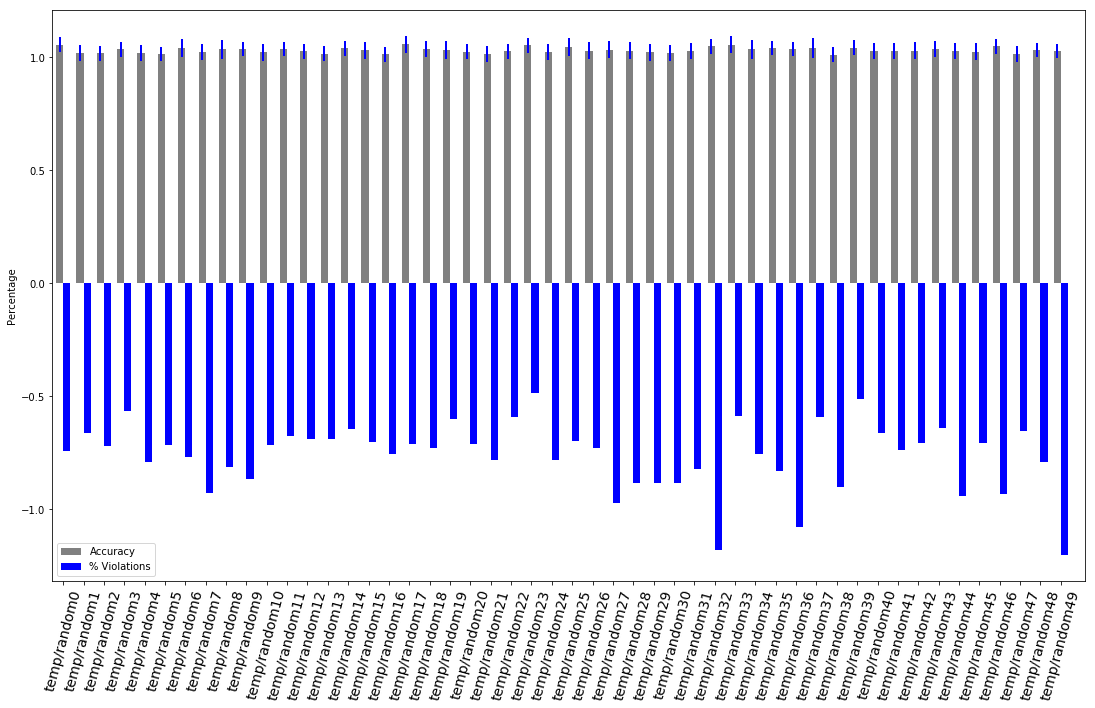

temp/random0
Area under surface (rectangular approx) =  58.76962938853924
Violations =  0.0
Average_violations =  -0.7438808714330353
MSE =  1.0546874160728301
temp/random1
Area under surface (rectangular approx) =  55.977138713486056
Violations =  0.0
Average_violations =  -0.6659471915856855
MSE =  1.0176499922772726
temp/random2
Area under surface (rectangular approx) =  67.05459412099488
Violations =  0.0
Average_violations =  -0.7210205539992576
MSE =  1.0167957060373218
temp/random3
Area under surface (rectangular approx) =  54.41682567905548
Violations =  0.0
Average_violations =  -0.5687341942755924
MSE =  1.0338554801812816
temp/random4
Area under surface (rectangular approx) =  65.15143081837569
Violations =  0.0
Average_violations =  -0.7939659723808095
MSE =  1.0186968778464343
temp/random5
Area under surface (rectangular approx) =  56.559414936121996
Violations =  0.0
Average_violations =  -0.7197591841040283
MSE =  1.0150139724032319
temp/random6
Area under surface (recta

In [6]:
metric = []
metric_err = []
viol = []
viol_err = []

#normalize the violations for prettier graphing.
#also violations are always positive, so just divide by max.

#TMK
#violation_mean = violation_mean / np.max(violation_mean)

for i in range(len(violations)):
    print("Model_name = ", model_names[i], "Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]), np.std(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]), np.std(mean[i]))
    #print("mean = ", mean[i])
    metric.append(np.mean(mean[i]))
    metric_err.append(np.std(mean[i]))
    viol.append(np.mean(violation_mean[i]))
    #viol.append(violations[i]/times)
    viol_err.append(np.std(violation_mean[i]))
print(np.array(metric), 
         np.array(metric_err), 
         np.array(viol), 
         np.array(viol_err))    

bar_plot(model_names, 
         np.array(metric), 
         np.array(metric_err), 
         np.array(viol), 
         np.array(viol_err))


def heat_plot(x,y,z, xlab = 'Mean', ylab = 'Variance', clim_low = 0, clim_high = 1):
    fig, ax = plt.subplots()

    cax = ax.scatter(x, y, c=z, s=450, edgecolor='')
    cax.set_clim(clim_low, clim_high)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    plt.colorbar(cax)
    plt.show()

    
MSE = []
VIO = []
VIO2 = []
AUS = []
for i, m in enumerate(models):
    print(model_names[i])
    x = []
    y = []
    z = []
    
    
    rectangular_approx = 0
    for k, v in metrics_dicts[i].items():
        x.append(float(k.split('_')[0]))
        y.append(float(k.split('_')[-1]))
        z.append(np.mean(v))
        rectangular_approx += np.mean(v)
    print("Area under surface (rectangular approx) = ", rectangular_approx)
    print("Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]))   
    MSE.append(np.mean(mean[i]))
    VIO.append(np.mean(violation_mean[i]))
    VIO2.append(np.mean(violation_mean2[i]))
    #VIO.append(violations[i]/times)
    AUS.append(rectangular_approx)
    
    #heat_plot(x,y,z, clim_low = 0, clim_high = 10)
    
#heat_plot(MSE,VIO,AUS, xlab = 'MSE', ylab='Violations', clim_low = np.min(AUS), clim_high = np.max(AUS))
    
VIO = np.abs(VIO)
VIO2 = np.abs(VIO2)


0.26429425855302563


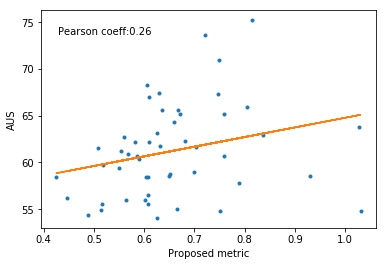

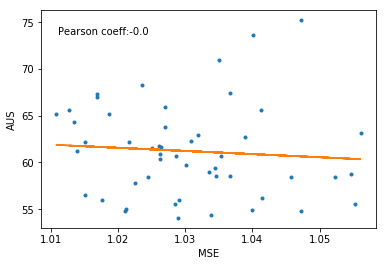

54.36678377234806 8.958043185434416


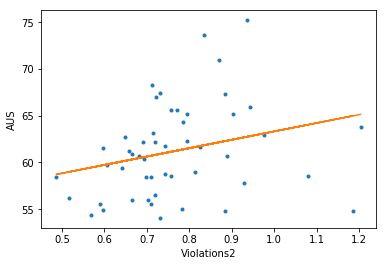

1.0361490876747637 -0.0075591024687269096


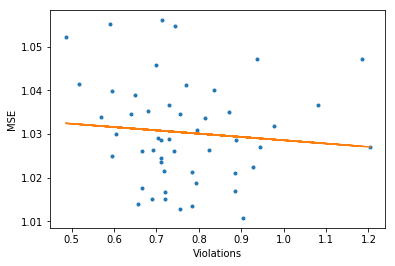

54.465969323715576 10.316514173651578


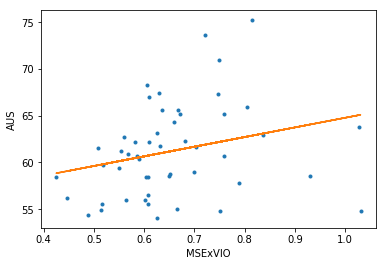

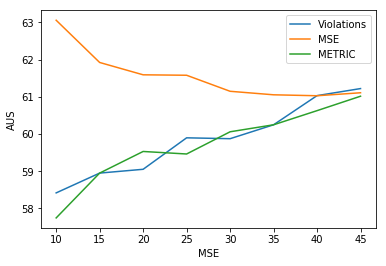

0.2615153080738294

In [7]:
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text

METRIC = (VIO/np.max(VIO)) * np.array(MSE)
print(pearsonr(METRIC,AUS)[0])
fig, ax = plt.subplots()
b,m = polyfit(METRIC,AUS, 1)
ax.plot(METRIC,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(METRIC,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Proposed metric")
ax.set_ylabel("AUS")
fig.savefig('Ex2ProposedVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,AUS, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
fig.savefig('Ex2MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(VIO2,AUS, 1)
print(b,m)
ax.plot(VIO2,AUS, '.')
plt.plot(VIO2, b + m * np.array(VIO2), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Violations2")
ax.set_ylabel("AUS")
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(VIO,MSE, 1)
print(b,m)
ax.plot(VIO,MSE, '.')
plt.plot(VIO, b + m * np.array(VIO), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Violations")
ax.set_ylabel("MSE")
plt.show()



fig, ax = plt.subplots()
b,m = polyfit(METRIC,AUS, 1)
print(b,m)
ax.plot(METRIC,AUS, '.')
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSExVIO")
ax.set_ylabel("AUS")
plt.show()

MSE = np.array(MSE)
METRIC = VIO/np.max(VIO)+ MSE
x = []
y1 = []
y2 = []
y3 = []
for split in range(10, len(AUS), 5):
    #print("******", split, "*******")
    sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(VIO,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]

    x.append(split)
    
    
    #print("Low Violations = ", np.mean(low), "for", len(low))
    #print("High Violations = ", np.mean(high), "for", len(high))
    y1.append(np.mean(low))
    sorted_aus_by_mse = [AUS for _,AUS in sorted(zip(MSE,AUS))]
    low = sorted_aus_by_mse[:split]
    high = sorted_aus_by_mse[split:]
    #print("Low AUS by MSE = ", np.mean(low), "for", len(low))
    #print("High AUS by MSE = ", np.mean(high), "for", len(high))
    y2.append(np.mean(low))
    sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(METRIC,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]



    #print("Low Metric = ", np.mean(low), "for", len(low))
    #print("High Metric = ", np.mean(high), "for", len(high))
    y3.append(np.mean(low))
    

fig, ax = plt.subplots()

ax.plot(x,y1, '-', label = 'Violations')
ax.plot(x,y2, '-', label = 'MSE')
ax.plot(x,y3, '-', label = 'METRIC')
ax.legend()

ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
plt.show()  
pearsonr(METRIC,AUS)[0]

2371585

In [9]:
pearsonr(METRIC,AUS)[0]

0.2615153080738294